# Limb darkening with PAVO

We want to compare the observed limb darkening from PAVO with models. But how can we go about that? We only have observations up to the first sidelobe so far. This essentially means that we can constrain one limb-darkening coefficient. But the linear limb-darkening law is known to not be a good physical representation. Moreover, the linear law is a poor fit to modelled intensities as a funciton of $\mu$.

What we can do is use higher-order limb-darkening laws, such as the 4-term law of Claret (2000), to fit the intensity profile from model atmopsheres. Then we find the linear limb-darkening coefficient that would give the same fringe visbilities in the sidelobe as would be obtained with the higher-order law. This equivalent linear coefficient can then be compared to the linear coefficient fitted to the observations.

Another suggestion has been to take higher-order coefficients from model values, and then just allow the linear term to vary when fitting to the observations. This then means that the observations are fitted with a more realistic-looking (although model-dependent) profile. The coefficient fitted to the data can then be compared to the value in the model. One criticism could be that this ties the fit to the observations to the models, when it would be ideal to keep them separate.

To begin, we're going to start with the first method. So we need to find a way to calculate the _equivalent linear limb-darkening coefficient_ from model atmospheres.

In [1]:
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special as sp
import plotly.plotly as py
from plotly.graph_objs import *

from scipy import optimize
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
from pavo_ld import V_from_claret
from pavo_ld import get_elc
from pavo_ld import read_regner
from pavo_ld import elc_interp


Calulate the visibility from a polynomial limb-darkening law. V_from_claret(xs,ks,cs) calculates the visibility at ordinates 'xs', with the limb-darkening law having coefficients 'cs' for 'ks' powers of $\mu$.

As an example, this is the visibility determined from Regner's coefficients for a solar model atmosphere at one of the PAVO wavelengths:

In [2]:
k = np.array([0.5,1.0,1.5,2.0])
c = np.array([0.39884645,0.49304062,-0.11547578,-0.02092264])
vis = V_from_claret(np.array([5.4]),k,c)
print('V^2 = ' + repr(vis**2))

V^2 = array([[0.01155042]])


What is an equivalent linear coefficient? From trial-and-error, u = 0.5275 works.

In [3]:
vis0 = V_from_claret(np.array([5.4]),np.array([1.0]),np.array([0.5275]))
print('V^2 = ' + repr(vis0**2))
print('Difference = ' + repr(vis**2-vis0**2))

V^2 = array([[0.01155048]])
Difference = array([[-6.0637322e-08]])


Obviously we shouldn't do this by trial and error. We need to be able to interpolate a grid of coefficients based on model atmospeheres to match the properties of our target stars (including uncertainties), and obtain the linear equivalent for each PAVO wavelength channel. 

Furthermore, to get really good agreement across a wider range of spatial frequencies, the fitted angular diameter can be scaled. So for a given set of model coefficients, we need to not only find the best equivalent linear coefficient, but a scale factor.

In [4]:
xs = np.arange(0.1,40,0.1)
vis = V_from_claret(xs,k,c)
vis0 = V_from_claret(xs,np.array([1.0]),np.array([0.5275]))
vis0s = V_from_claret(xs*0.993,np.array([1.0]),np.array([0.5275]))

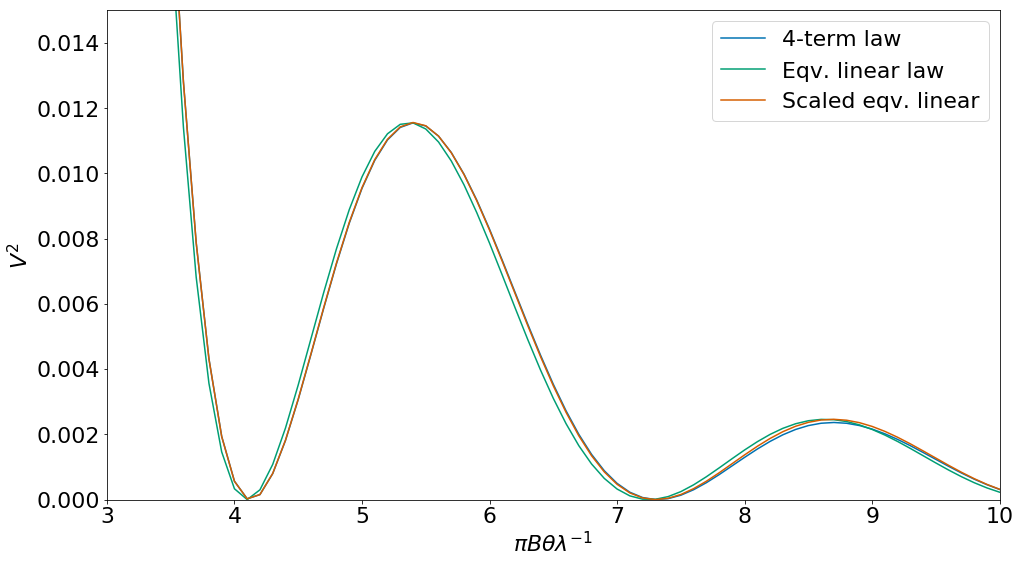

In [5]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 22,
        }

matplotlib.rc('font', **font)
sns.set_palette(sns.color_palette("colorblind"))

fig = plt.figure(figsize=(16,9))

plt.plot(xs,vis**2,label='4-term law')
plt.plot(xs,vis0**2,label='Eqv. linear law')
plt.plot(xs,vis0s**2,label='Scaled eqv. linear')
plt.ylim([0,0.015])
plt.xlim([3,10])
plt.xlabel('$\pi B \\theta \lambda^{-1}$', fontdict=font)
plt.ylabel('$V^2$', fontdict=font)
plt.legend()

plt.show()

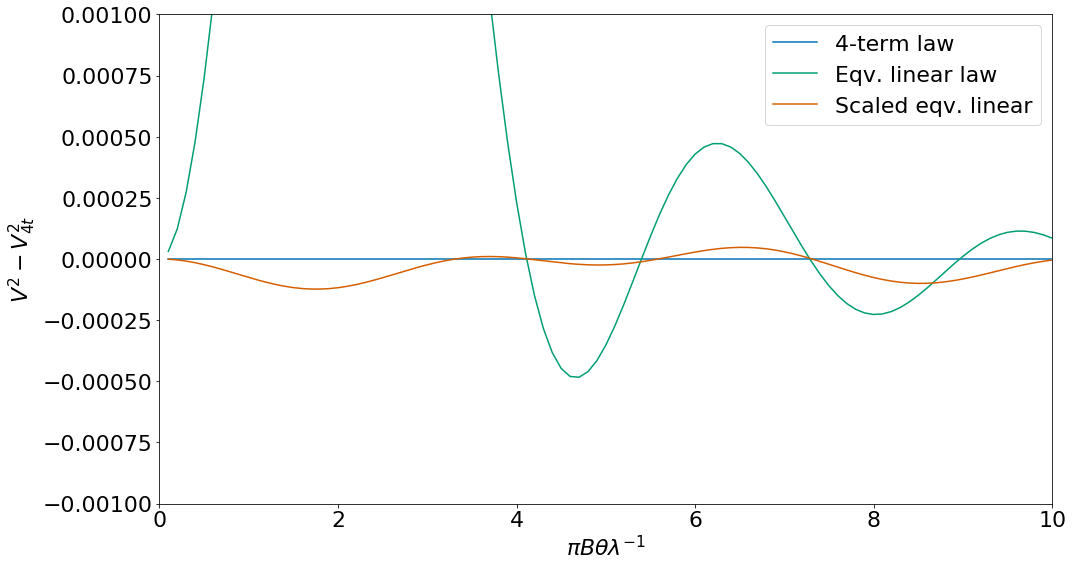

In [6]:
fig = plt.figure(figsize=(16,9))
plt.plot(xs,(vis**2-vis**2),label='4-term law')
plt.plot(xs,(vis**2-vis0**2),label='Eqv. linear law')
plt.plot(xs,(vis**2-vis0s**2),label='Scaled eqv. linear')
plt.xlim([0,10])
plt.ylim([-0.001,0.001])
plt.xlabel('$\pi B \\theta \lambda^{-1}$', fontdict=font)
plt.ylabel('$V^2-V^2_{4t}$', fontdict=font)
#plt.ylim([0.9,1.1])
plt.legend()

plt.show()

The scaling only affects the visibility curve in the x direction, while the limb-darkening coefficient affects the height of the sidelobe, and to a lesser degree its shape. We can therefore find the best values for the radius scaling term and the equivalent linear coefficient separately.

* Determine how the maximum value of the visibility curve in the sidelobe varies as a function of the linear-limb darkening parameter ($u$) by:
    - Numerically find $V^2_\mathrm{max, lin}$ for $u$ between 0 and 1.
    - Fit a polynomial to $V^2_\mathrm{max, lin}$ as a function of $u$.
* Determine $V^2_\mathrm{max, 4t}$ for the 4-term limb-darkening law for the particular set of coefficients.
* Find the value of $u$ where $V^2_\mathrm{max, lin}(u) = V^2_\mathrm{max, 4t}$. This is the equivalent linear coefficient.
* Determine the values of $x = \pi B \theta \lambda^{-1}$ that give $V^2_\mathrm{max, lin}$ and $V^2_\mathrm{max, 4t}$. The scale factor is the ratio of the two x values.


In [7]:
xs = np.arange(5.1,5.8,0.0001)
us = np.arange(0,1.001,0.001)

'''This takes a long time to run, and only needs to be run once to determine the coefficients
of the polynomial. Therefore, skip running this.
'''
# mv0s = []
# #mx0s = []

# for u in zip(us):
#     vis0 = V_from_claret(xs,[1.0],u)
#     mv0s.append(vis0.min())
#     #mx0s.append(xs[vis0.argmin()])
# mv0s = np.array(mv0s)
# #mx0s = np.array(mx0s)
# z = np.polyfit(us,mv0s**2,11)

z = [2.61861994e-06,1.87429278e-05,-6.07351449e-05,9.25521846e-05,-6.72508875e-05,8.32951276e-05,1.48187938e-04,4.58261148e-04,8.69003259e-04,-8.78512128e-05,-1.15292637e-02,1.74978628e-02]
p = np.poly1d(z)

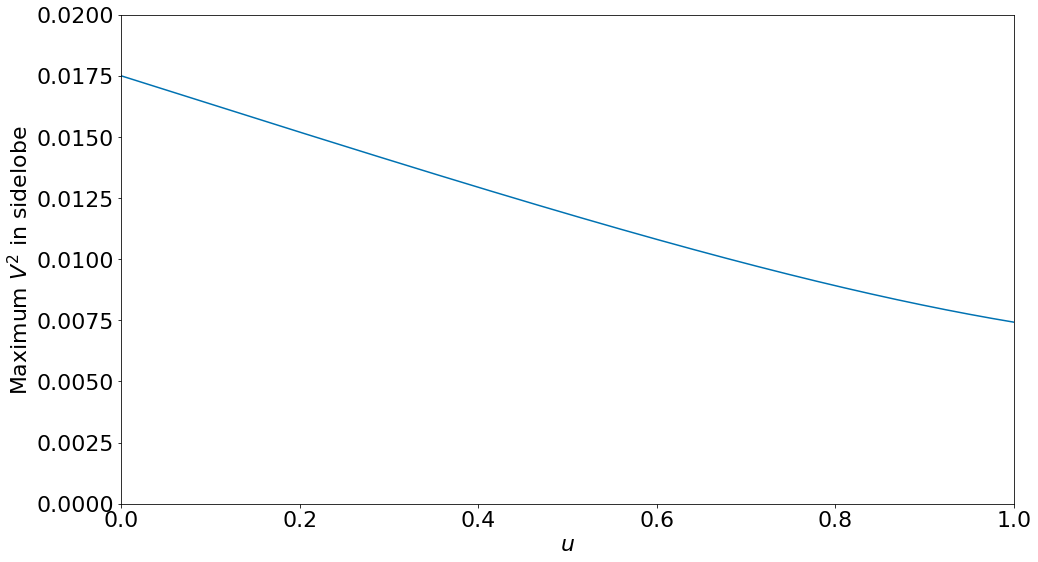

In [8]:
fig = plt.figure(figsize=(16,9))
#plt.plot(us,mv0s**2)
plt.plot(us,p(us))
plt.xlim([0,1])
plt.ylim([0,0.02])
plt.xlabel('$u$', fontdict=font)
plt.ylabel('Maximum $V^2$ in sidelobe', fontdict=font)

plt.show()

In [9]:
vis = V_from_claret(xs,k,c)
mv = vis.min()
mx = xs[vis.argmin()]
print('Maximum V^2 for the 4-term law is ' + repr(mv**2) + ' at x of ' + repr(mx))

elc = optimize.brentq(p-mv**2,0,1)
print('The equivalent linear coefficient that gives the same maximum V^2 is ' + repr(elc))

Maximum V^2 for the 4-term law is 0.01155128557438186 at x of 5.40859999999928
The equivalent linear coefficient that gives the same maximum V^2 is 0.5285385579856037


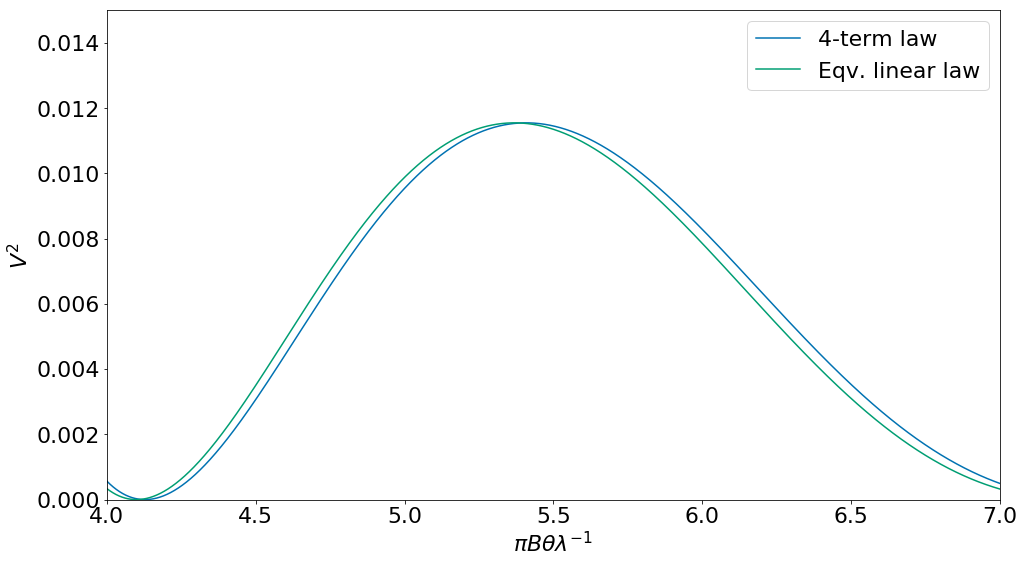

In [10]:
k = np.array([0.5,1.0,1.5,2.0])
c = np.array([0.39884645,0.49304062,-0.11547578,-0.02092264])
xs = np.arange(0.1,10,0.0001)
vis = V_from_claret(xs,np.array(k),np.array(c))
vis0 = V_from_claret(xs,np.array([1.0]),np.array([elc]))

fig = plt.figure(figsize=(16,9))

plt.plot(xs,vis**2,label='4-term law')
plt.plot(xs,vis0**2,label='Eqv. linear law')
plt.ylim([0,0.015])
plt.xlim([4,7])
plt.xlabel('$\pi B \\theta \lambda^{-1}$', fontdict=font)
plt.ylabel('$V^2$', fontdict=font)
plt.legend()

plt.show()

Now find the scaling factor

In [11]:
mv = vis.min()
mx = xs[vis.argmin()]
print('Maximum V^2 is ' + repr(mv**2) + ' at x of ' + repr(mx))

mv0 = vis0.min()
mx0 = xs[vis0.argmin()]
print('Maximum V^2 is ' + repr(mv0**2) + ' at x of ' + repr(mx0))

scl = mx0/mx
print('Scale by ' + repr(scl))

Maximum V^2 is 0.011551285574381847 at x of 5.408600000000152
Maximum V^2 is 0.011551285520614423 at x of 5.3691000000001505
Scale by 0.9926968161816366


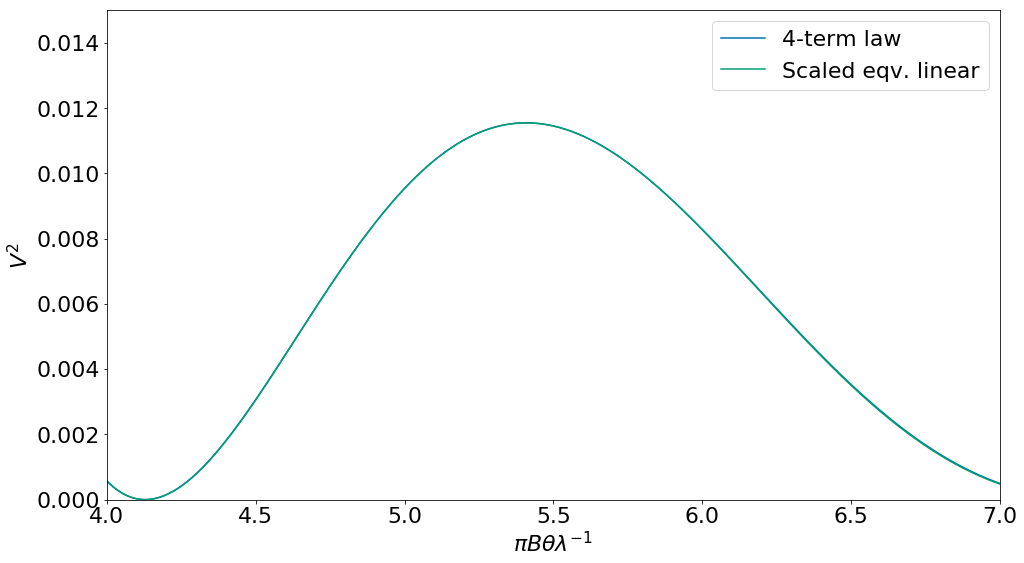

In [12]:
vis0s = V_from_claret(xs*scl,np.array([1.0]),np.array([elc]))

fig = plt.figure(figsize=(16,9))

plt.plot(xs,vis**2,label='4-term law')
#plt.plot(xs,vis0**2,label='Eqv. linear law')
plt.plot(xs,vis0s**2,label='Scaled eqv. linear')
plt.ylim([0,0.015])
plt.xlim([4,7])
plt.xlabel('$\pi B \\theta \lambda^{-1}$', fontdict=font)
plt.ylabel('$V^2$', fontdict=font)
plt.legend()

plt.show()

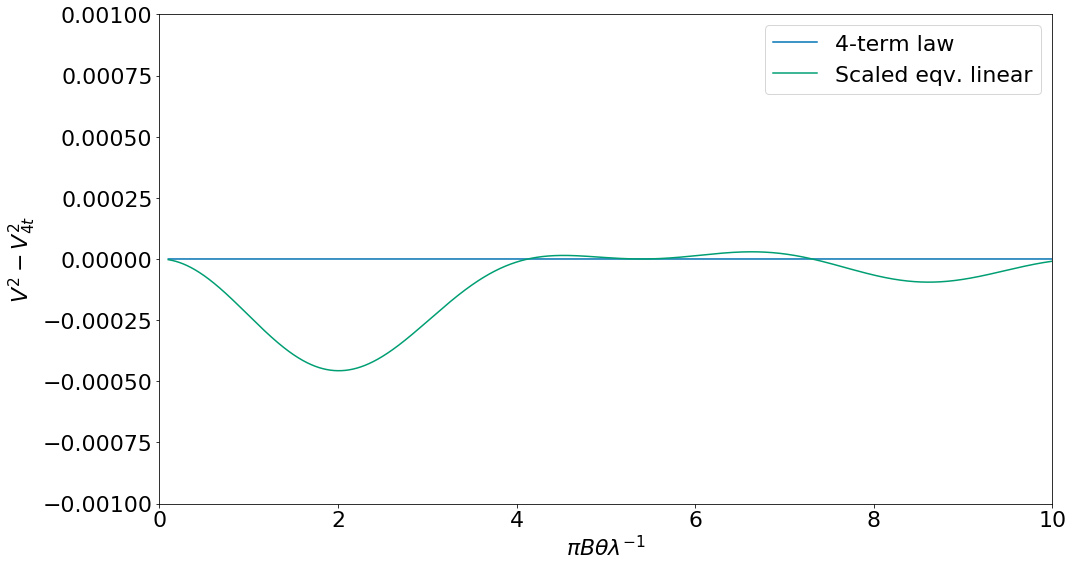

In [13]:
fig = plt.figure(figsize=(16,9))
plt.plot(xs,(vis**2-vis**2),label='4-term law')
#plt.plot(xs,(vis**2-vis0**2),label='Eqv. linear law')
plt.plot(xs,(vis**2-vis0s**2),label='Scaled eqv. linear')
plt.xlim([0,10])
plt.ylim([-0.001,0.001])
plt.xlabel('$\pi B \\theta \lambda^{-1}$', fontdict=font)
plt.ylabel('$V^2-V^2_{4t}$', fontdict=font)
#plt.ylim([0.9,1.1])
plt.legend()

plt.show()

Now this works for a single set of limb-darkening coefficients, it needs to be set up to accept a set of these, one for each PAVO wavelength. First set it up to work for any particular model from Regner's grid, and then generalize it to allow interpolation between models.

In [14]:
elc, scl = get_elc(k,c)
elc, scl

([0.5285385579856037], array([0.99269682]))

Regner's file is quite large: Thirty-seven stellar atmopshere models, with four coefficeints calculated for each of PAVO's 38 wavelength channels.

In [15]:
data = read_regner('PAVO.tab')

-0.4531966582111471
-0.4748514329354926


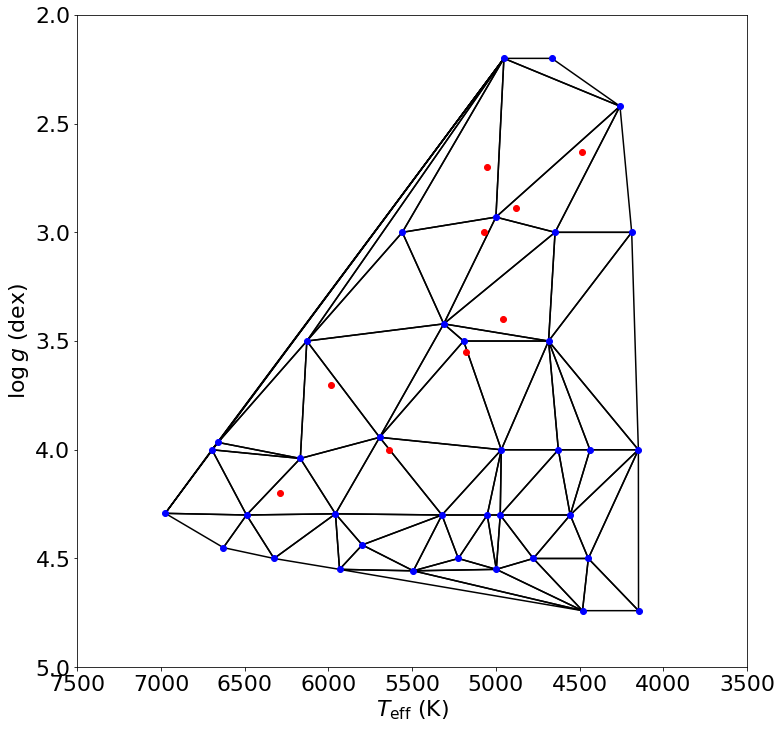

In [16]:
# Triangulate
loggs = []
teffs = []
a1s = []
a2s = []
a3s = []
a4s = []
for d in data:
    logg = d['logg']
    teff = d['teff']
    a1 = d['00']['a1']
    a2 = d['00']['a2']
    a3 = d['00']['a3']
    a4 = d['00']['a4']    
    loggs.append(logg)
    teffs.append(teff)
    a1s.append(a1)
    a2s.append(a2)
    a3s.append(a3)
    a4s.append(a4)

points2D = np.vstack([np.log10(teffs),np.log10(loggs)]).T
tri = Delaunay(points2D)

def tri_indices(simplices):
    return ([triplet[c] for triplet in simplices] for c in range(3))

fig = plt.figure(figsize=(12,12))
for v in tri.simplices:
    plt.plot([teffs[v[0]],teffs[v[1]],teffs[v[2]],teffs[v[0]]],[loggs[v[0]],loggs[v[1]],loggs[v[2]],loggs[v[0]]],'k')
v = tri.simplices[0]
plt.plot(teffs,loggs,'bo')


#Find values for a particular channel
plt.plot([4960,5636,5983,5178,4878,4484,5070,6289,5051],[3.4,4.0,3.7,3.55,2.89,2.63,3.0,4.2,2.7],'ro')
resLa1 = LinearNDInterpolator(tri,a1s)
resLa2 = LinearNDInterpolator(tri,a2s)
resLa3 = LinearNDInterpolator(tri,a3s)
resLa4 = LinearNDInterpolator(tri,a4s)
print(resLa4(np.log10(4960),np.log10(3.4)))

resCTa1 = CloughTocher2DInterpolator(tri,a1s)
resCTa2 = CloughTocher2DInterpolator(tri,a2s)
resCTa3 = CloughTocher2DInterpolator(tri,a3s)
resCTa4 = CloughTocher2DInterpolator(tri,a4s)
print(resCTa4(np.log10(4960),np.log10(3.4)))

plt.xlim([7500,3500])
plt.ylim([5,2])
plt.xlabel('$T_\mathrm{eff}$ (K)', fontdict=font)
plt.ylabel('$\log\, g$ (dex)', fontdict=font)


plt.show()



In [17]:
#Values to be interpolated to
t1 = np.log10((4960.))
l1 = np.log10((3.4))

# t1 = np.log10((4960.))
# l1 = np.log10((3.4))

# Define wavelength channels
channels = d.keys()
channels.remove('teff')
channels.remove('sigteff')
channels.remove('logg')
channels.remove('feh')
ks = [0.5,1.0,1.5,2.0]

channels.sort()

wls = []
elcsL = []
sclsL = []
elcsCT = []
sclsCT = []

ftcs = []

# Loop over wavlength channels and perform interpolation
for c in channels:
    a1s = []
    a2s = []
    a3s = []
    a4s = []
    for d in data:
        ch = d[c]
        a1s.append(ch['a1'])
        a2s.append(ch['a2'])
        a3s.append(ch['a3'])
        a4s.append(ch['a4'])
    
    resLa1 = LinearNDInterpolator(tri,a1s)
    resLa2 = LinearNDInterpolator(tri,a2s)
    resLa3 = LinearNDInterpolator(tri,a3s)
    resLa4 = LinearNDInterpolator(tri,a4s)
    
    resCTa1 = CloughTocher2DInterpolator(tri,a1s)
    resCTa2 = CloughTocher2DInterpolator(tri,a2s)
    resCTa3 = CloughTocher2DInterpolator(tri,a3s)
    resCTa4 = CloughTocher2DInterpolator(tri,a4s)
        
    csL = [resLa1(t1,l1),resLa2(t1,l1),resLa3(t1,l1),resLa4(t1,l1)]
    csCT = [resCTa1(t1,l1),resCTa2(t1,l1),resCTa3(t1,l1),resCTa4(t1,l1)]
    
    #print(resLa1(t1,l1))
    
    wls.append(ch['wl'])
    ftcs.append(np.asarray(csCT))
    elc, scl = get_elc(k,csL)
    elcsL.append(elc)
    sclsL.append(scl)
    elc, scl = get_elc(k,csCT)
    elcsCT.append(elc)
    sclsCT.append(scl)


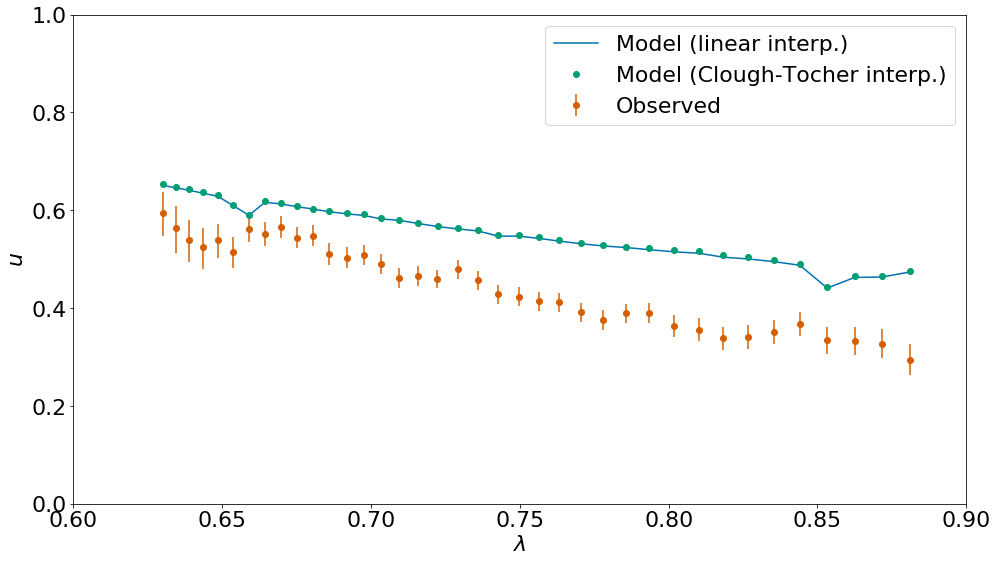

In [18]:
fig = plt.figure(figsize=(16,9))
plt.plot(wls,elcsL,label='Model (linear interp.)')
plt.plot(wls,elcsCT,'o',label='Model (Clough-Tocher interp.)')
plt.xlim([0.6,0.9])
plt.ylim([0,1])
plt.xlabel('$\lambda$', fontdict=font)
plt.ylabel('$u$', fontdict=font)

lam=[]
ld=[]
ldhi=[]
ldlo=[]
with open('etaCep_wlld.dat','r') as f:
    for line in f:
        line = line.strip()
        columns = line.split()
        lam.append(float(columns[0]))
        ld.append(float(columns[1]))
        ldhi.append(float(columns[2]))
        ldlo.append(float(columns[3]))
        
plt.errorbar(lam,ld, yerr = [ldlo, ldhi], fmt='o', label='Observed')

plt.legend()

plt.show()

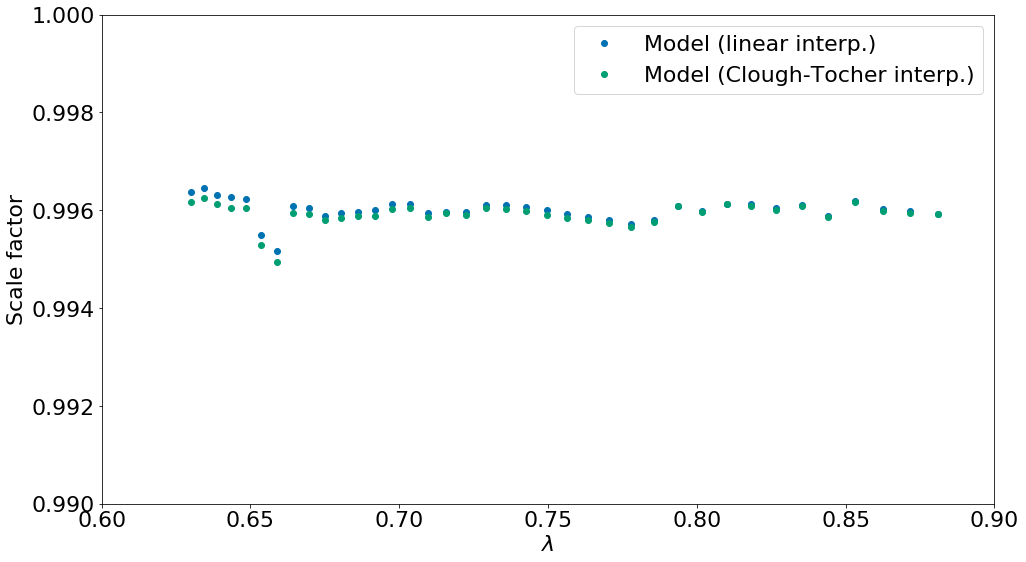

In [19]:
fig = plt.figure(figsize=(16,9))
plt.plot(wls,sclsL,'o',label='Model (linear interp.)')
plt.plot(wls,sclsCT,'o',label='Model (Clough-Tocher interp.)')
plt.xlim([0.6,0.9])
plt.ylim([0.99,1.0])
plt.xlabel('$\lambda$', fontdict=font)
plt.ylabel('Scale factor', fontdict=font)


plt.legend()

plt.show()

How do the intensity profiles of the two laws compare?

In [27]:
def linld(mus,u):
    intensity = 1.-u*(1.-mus)
    return intensity

def ftld(mus,ks,cs):
    intensity = 1.
    for k, c in zip(ks, cs):
        intensity -= c*(1-mus**k)
    return intensity

mus = np.arange(0,1.001,0.001)

linint = linld(mus,elcsCT[15])
ftint = ftld(mus,ks,ftcs[15].T)


ValueError: operands could not be broadcast together with shapes (4,) (1001,) 

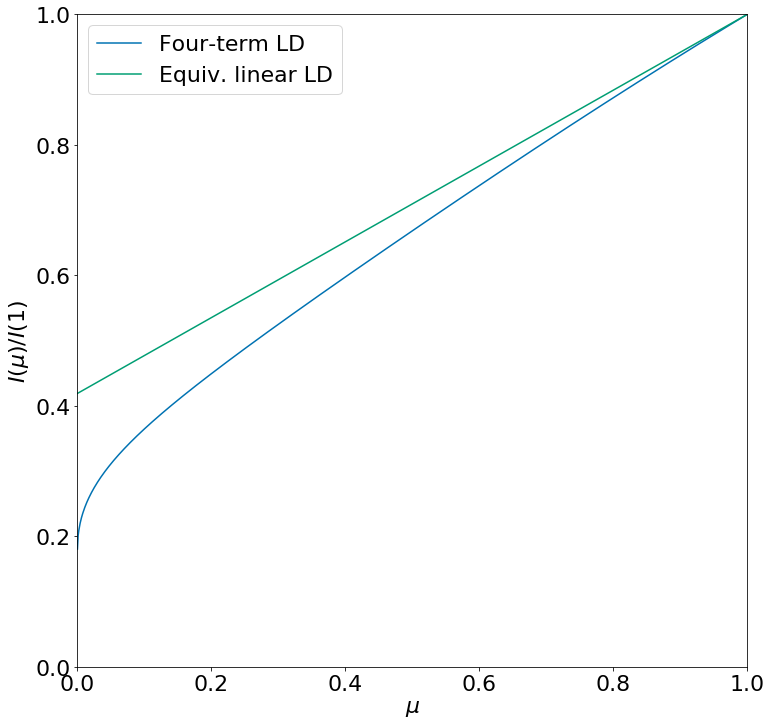

In [28]:
fig = plt.figure(figsize=(12,12))
plt.plot(mus,ftint,label='Four-term LD')
plt.plot(mus,linint,label='Equiv. linear LD')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$\mu$', fontdict=font)
plt.ylabel('$I(\mu) / I(1)$', fontdict=font)

plt.legend()

plt.show()

Now that this works, make it callable for any given $T_\mathrm{eff}$ and $\log g$.

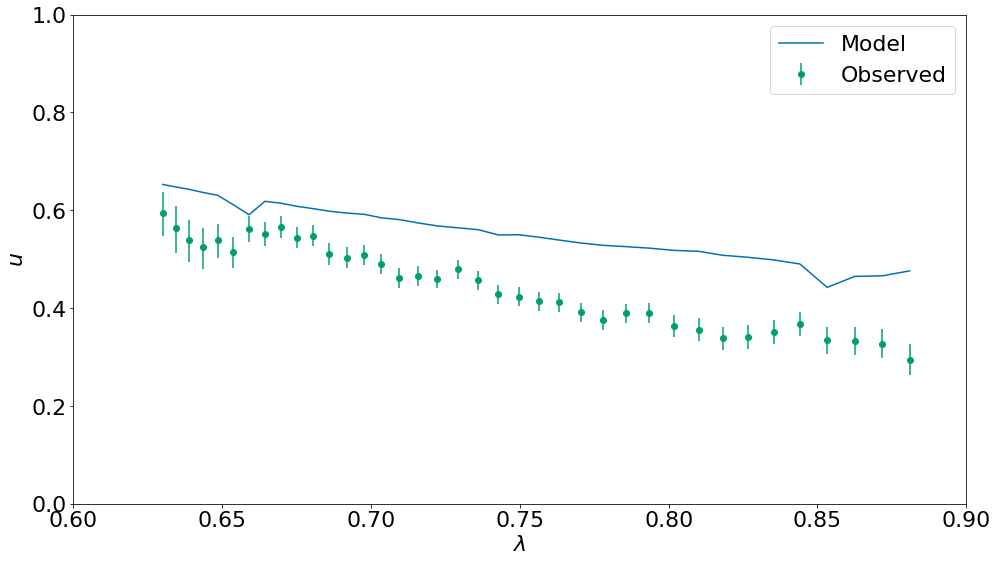

In [22]:
teff = 4960.
logg = 3.4
wls,elcs,scls,ftcs = elc_interp(teff,logg)

fig = plt.figure(figsize=(16,9))
plt.plot(wls,elcs,label='Model')
plt.xlim([0.6,0.9])
plt.ylim([0,1])
plt.xlabel('$\lambda$', fontdict=font)
plt.ylabel('$u$', fontdict=font)

lam=[]
ld=[]
ldhi=[]
ldlo=[]
with open('etaCep_wlld.dat','r') as f:
    for line in f:
        line = line.strip()
        columns = line.split()
        lam.append(float(columns[0]))
        ld.append(float(columns[1]))
        ldhi.append(float(columns[2]))
        ldlo.append(float(columns[3]))
        
plt.errorbar(lam,ld, yerr = [ldlo, ldhi], fmt='o', label='Observed')

plt.legend()

plt.show()

Now we need to consider the uncertainties in the observed $T_\mathrm{eff}$ and $\log g$, and the impact they have on the model coefficient(s).

In [23]:
sigteff = 50.
siglogg = 0.1

teff1 = sigteff * np.random.randn(100) + teff
logg1 = siglogg * np.random.randn(100) + logg

wls,elcs,scls,ftcs = elc_interp(teff,logg)

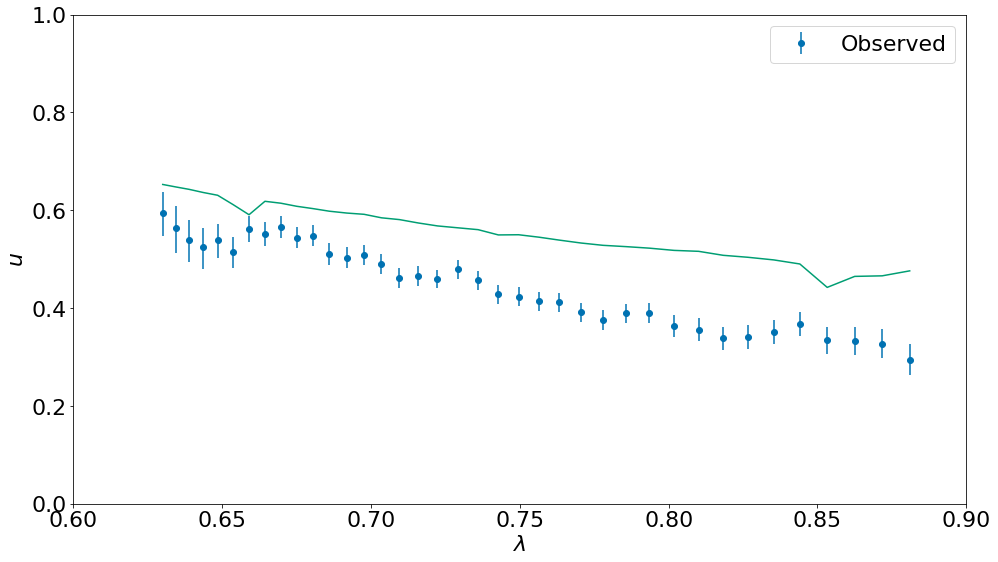

In [24]:
fig = plt.figure(figsize=(16,9))

lam=[]
ld=[]
ldhi=[]
ldlo=[]
with open('etaCep_wlld.dat','r') as f:
    for line in f:
        line = line.strip()
        columns = line.split()
        lam.append(float(columns[0]))
        ld.append(float(columns[1]))
        ldhi.append(float(columns[2]))
        ldlo.append(float(columns[3]))
        
plt.errorbar(lam,ld, yerr = [ldlo, ldhi], fmt='o', label='Observed')

plt.plot(wls,elcs,'-')
plt.xlim([0.6,0.9])
plt.ylim([0,1])
plt.xlabel('$\lambda$', fontdict=font)
plt.ylabel('$u$', fontdict=font)

plt.legend()

plt.show()

In [25]:
wls,elcs,scls,ftcs = elc_interp(teff,logg)

In [26]:
wls,elcs,scls,ftcs = elc_interp([teff,teff],[logg,logg])